In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import netket as nk
import optax
import netket.jax as nkjax
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os
import json
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate

from grad_sample.tasks.fullsum_train import Trainer
from grad_sample.utils.is_distrib import *
from grad_sample.utils.plotting_setup import *
from grad_sample.is_hpsi.expect import *
from grad_sample.is_hpsi.qgt import QGTJacobianDenseImportanceSampling
from grad_sample.is_hpsi.operator import IS_Operator
from netket.jax._jacobian.logic import _multiply_by_pdf
from grad_sample.utils.tree_op import dagger_pytree, vjp_pytree, mul_pytree, shape_tree, pytree_mean
from grad_sample.tasks.fullsum_snr_is import _compute_S_F, _compute_S_F_var

In [3]:
import seaborn as sns
sns.set_context('talk', font_scale=1.1)

In [4]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="train_is")
    OmegaConf.set_struct(cfg, True)
    print(cfg)
    print(cfg.task)
    # cfg = OmegaConf.to_yaml(cfg)
    # take any task from cfg and run it
# analysis = FullSumPruning(cfg)
trainer = Trainer(cfg)

{'device': '2', 'auto_is': True, 'lr': 0.0022, 'diag_shift': 0.0001, 'n_iter': 2000, 'sample_size': 9, 'chunk_size_jac': 1024, 'chunk_size_vmap': 100, 'save_every': None, 'run_index': None, 'base_path': '/scratch/.amisery/grad_sample_test/', 'model': {'_target_': 'grad_sample.models.heisenberg.XXZ', 'J': 1.5, 'L': 16}, 'ansatz': {'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}, 'task': {'_target_': 'grad_sample.tasks.fullsum_train.Trainer'}, 'solver_fn': {'_target_': 'netket.optimizer.solver.cholesky'}, 'sampler': {'_target_': 'netket.sampler.ExactSampler'}, 'is_distrib': {'_target_': 'auto_importance.driver.default_distribution'}}
{'_target_': 'grad_sample.tasks.fullsum_train.Trainer'}
MC state loaded, num samples 512
/scratch/.amisery/grad_sample_test//xxz_1.5/L16/RBM/alpha3/MC_9/0.0022_0.0001/run_3
The ground state energy is: -33.71105604086467


In [5]:
from netket.vqs import FullSumState
import copy
def compute_snr_callback(step, logdata, driver):
    # estimate local grad
    if step %10 == 0:
        fs_state = FullSumState(hilbert = driver.state.hilbert, model = driver.state.model, chunk_size=None, seed=0)
        fs_state.variables = copy.deepcopy(driver.state.variables)
        pdf = fs_state.probability_distribution()
        vstate_arr = fs_state.to_array()
        Hloc = driver._ham @ vstate_arr / vstate_arr
        Hloc_c = (Hloc - jnp.sum(Hloc*pdf))
        # mode='holomorphic'
        # jacobian_orig = nkjax.jacobian(
        #     fs_state._apply_fun,
        #     fs_state.parameters,
        #     fs_state.hilbert.all_states(), #in MC state, this is vstate.samples
        #     fs_state.model_state,
        #     pdf=pdf,
        #     mode=mode,
        #     dense=True,
        #     center=False,
        #     chunk_size=10,
        #     _sqrt_rescale=False, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
        # )
        # jacobian_orig_c = jacobian_orig - jnp.sum(jacobian_orig*jnp.expand_dims(pdf, range(len(jacobian_orig.shape))[1:]),axis=0)
       
        # loc_grad_v_holo = jacobian_orig_c.conj().T * Hloc_c
        # print(loc_grad_v_holo.shape)

        mode = "complex"
        # uncentered jacobian
        jacobian_orig = nkjax.jacobian(
            fs_state._apply_fun,
            fs_state.parameters,
            fs_state.hilbert.all_states(), #in MC state, this is vstate.samples
            fs_state.model_state,
            pdf=pdf,
            mode=mode,
            dense=True,
            center=False,
            chunk_size=10,
            _sqrt_rescale=False, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
        )

        # (#ns, 2) -> (#ns*2)
        Hloc_2 = jnp.stack([jnp.real(Hloc_c), jnp.imag(Hloc_c)], axis=-1)
        Hloc_c = jax.lax.collapse(Hloc_2, 0, 2)
        jacobian_orig_c = jacobian_orig - jnp.sum(jacobian_orig*jnp.expand_dims(pdf, range(len(jacobian_orig.shape))[1:]),axis=0)
        jacobian_orig_c = jax.lax.collapse(jacobian_orig_c, 0, 2)
        loc_grad_v = jacobian_orig_c.T * Hloc_c
        loc_grad_v = loc_grad_v[:, ::2] + loc_grad_v[:, 1::2]
        
        # print(loc_grad_v.shape)
        # n_p = loc_grad_v.shape[0]//2
        # print(loc_grad_v_holo - (loc_grad_v[:n_p,:] + 1j* loc_grad_v[n_p:,:]))


        mean_grad_unc = jnp.sum(jnp.abs(pdf * loc_grad_v), axis=0) / jnp.sum(jnp.abs(pdf * loc_grad_v))
        
        def unnorm_pdf(alpha):
            return (jnp.abs(vstate_arr)**alpha)
        
        def compute_snr(q):
            q_pdf = q / jnp.sum(q)
            w_mean = jnp.sum(q_pdf * unnorm_pdf(2.0)/q)**2
            v = jnp.sum(q_pdf * (unnorm_pdf(2.0)/q)**2 * jnp.abs(loc_grad_v - jnp.sum(pdf * loc_grad_v, axis=1)[:, None])**2, axis=1)/w_mean
            return jnp.mean(jnp.abs(jnp.sum(pdf * loc_grad_v, axis = 1)) / jnp.sqrt(v))
        
        a_vals = jnp.linspace(0,2,50)
        snr_a = jnp.array([compute_snr(unnorm_pdf(a)) for a in a_vals])
        argmax_index = jnp.argmax(snr_a)
        argmax_a = a_vals[argmax_index]
        # print(jnp.mean(unnorm_pdf(2.0) * jnp.abs(loc_grad_v), axis=0).shape)
        snr_grad = compute_snr(jnp.mean(unnorm_pdf(2.0) * jnp.abs(loc_grad_v), axis=0))
        
        logdata['snr_a'] = snr_a
        logdata['snr_grad'] = snr_grad
        logdata['max_snr_a'] = max(snr_a)
        logdata['argmax_snr_a'] = argmax_a
        logdata['snr_psi_sq'] = compute_snr(unnorm_pdf(2.0))
        logdata['snr_hpsi'] = compute_snr(jnp.abs(driver._ham @ vstate_arr))
        logdata['grad_mag'] = jnp.mean(jnp.abs(loc_grad_v), axis=0)
    return True
        

In [6]:
import auto_importance as advd
def print_alpha_cb(step, logdata, driver):
    if step %10 == 0:
        print(driver._ham.is_mode)
    return True

def print_snr(step, logdata, driver):
    logdata['alpha'] = driver.sampling_distribution.q_variables['alpha'].item()
    return True

is_distrib = advd.driver.overdispersed_distribution(2.0)
gs = advd.driver.VMC_NG(hamiltonian=trainer.model.hamiltonian.to_jax_operator(), 
                        optimizer=trainer.opt, 
                        variational_state=trainer.vstate, 
                        sampling_distribution= is_distrib, 
                        diag_shift=1e-4,
                        auto_is=True
                        )
from grad_sample.utils.utils import save_rel_err_fs
fs_state_rel_err = FullSumState(hilbert = gs.state.hilbert, model = gs.state.model, chunk_size=None, seed=0)
        
save_rel_err_cb = partial(save_rel_err_fs, e_gs = trainer.E_gs, fs_state = fs_state_rel_err, save_every=10)

gs.run(n_iter=1500, out = nk.logging.JsonLog(output_prefix='out'), callback = (print_snr, compute_snr_callback, save_rel_err_cb))

 11%|█         | 159/1500 [01:02<08:50,  2.53it/s, Energy=-31.1+0.0j ± 1.4 [σ²=1251.8]]   

Stopped by user.


(JsonLog('out', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.19806432723999023
   	Params: 0.11504244804382324,)

In [ ]:

gs_fs = nk.driver.VMC(hamiltonian=trainer.model.hamiltonian.to_jax_operator(), 
                        optimizer=trainer.opt, 
                        variational_state=fs_state_rel_err, 
                        preconditioner=nk.optimizer.SR(qgt=nk.optimizer.qgt.QGTJacobianDense, solver=trainer.solver_fn, diag_shift=trainer.diag_shift, holomorphic= trainer.mode == "holomorphic")
                        )    

gs.run(n_iter=1500, out = nk.logging.JsonLog(output_prefix='out'), callback=(compute_snr_callback,save_rel_err_cb),)

  0%|          | 0/1500 [00:00<?, ?it/s]

  5%|▍         | 68/1500 [00:15<05:27,  4.37it/s, Energy=-22.80+0.07j ± 0.27 [σ²=32.54]]      

Stopped by user.


(JsonLog('out', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.03430938720703125
   	Params: 0.029723405838012695,)

In [ ]:
import jax.numpy as jnp

def find_indices(a, b):
    # Get indices where elements of b appear in a
    indices = jnp.searchsorted(a, b)
    
    # Verify that the values at these indices in a match b (handles missing elements)
    valid_mask = a[indices] == b
    
    return indices[valid_mask]  # Return only valid indices

[0 2 4 6 8]


In [2]:
out = json.load(open('out.log'))

In [5]:
good_vals = find_indices(jnp.array(out['alpha']['iters']), jnp.array(out['rel_err']['iters']))

In [13]:
rel_err_vals = jnp.array(out['rel_err']['value'])
idx_sort = jnp.flip(jnp.argsort(rel_err_vals))
rel_err_vals_s = rel_err_vals[idx_sort]

In [17]:
out.keys()

dict_keys(['Energy', 'info', 'alpha', 'snr_a', 'snr_grad', 'max_snr_a', 'argmax_snr_a', 'snr_psi_sq', 'snr_hpsi', 'grad_mag', 'rel_err'])

Text(0.5, 1.0, 'SNR and optimal overdispersion coefficient over training on the 16 sites XXZ model, RBM')

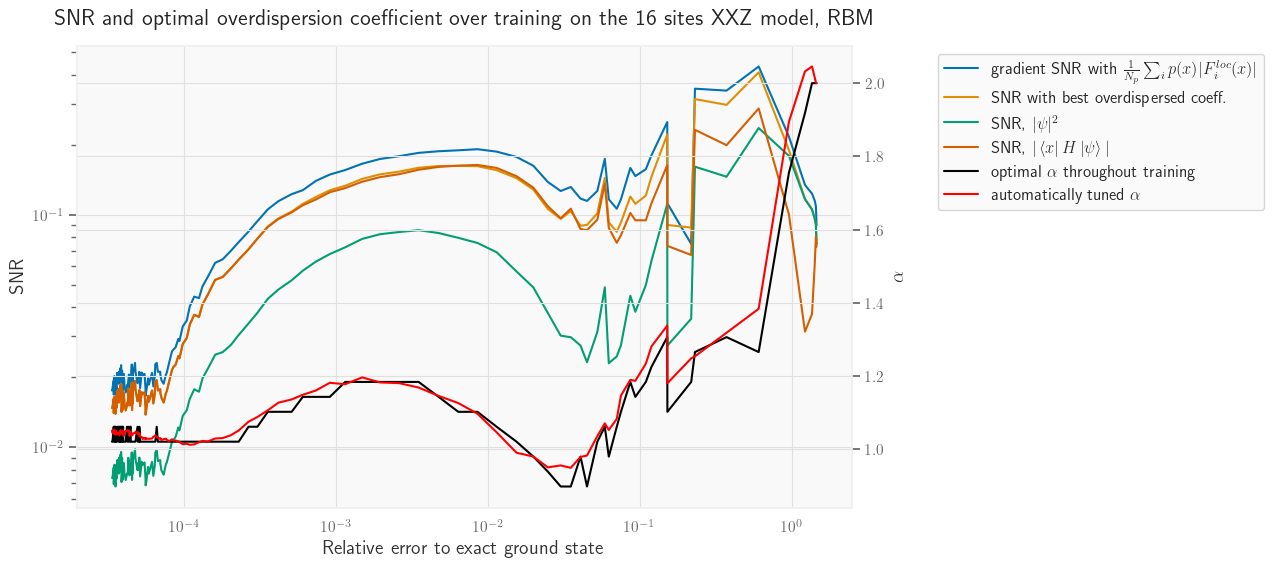

In [20]:
fig, ax = plt.subplots()

ax.plot(rel_err_vals_s, jnp.array(out['snr_grad']['value'])[idx_sort], label=r'gradient SNR with $\frac{1}{N_p}\sum_i p(x)|F_i^{loc}(x)|$')
ax.plot(rel_err_vals_s, jnp.array(out['max_snr_a']['value'])[idx_sort], label='SNR with best overdispersed coeff.')
ax.plot(rel_err_vals_s, jnp.array(out['snr_psi_sq']['value'])[idx_sort], label=r'SNR, $|\psi|^2$')
ax.plot(rel_err_vals_s, jnp.array(out['snr_hpsi']['value'])[idx_sort], label=r'SNR, $|\bra{x}H\ket{\psi}|$')
# ax.plot(rel_err_vals_s, jnp.array(out['info']['snr']['value'])[good_vals][idx_sort], label='SNR with best overdispersed coeff.')
ax1 = ax.twinx()

ax1.plot(rel_err_vals_s, jnp.array(out['argmax_snr_a']['value'])[idx_sort], color='black', label=r"optimal $\alpha$ throughout training")
ax1.plot(rel_err_vals_s, jnp.array(out['alpha']['value'])[good_vals][idx_sort], color='red', label=r'automatically tuned $\alpha$')
ax1.set_xscale('log')
ax.set_xlabel("Relative error to exact ground state")
ax.set_ylabel('SNR')
ax1.set_ylabel(r"$\alpha$")
ax.set_yscale('log')
ax.set_xscale('log')
# Retrieve and combine legends
handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
ax.legend(handles_ax + handles_ax1, labels_ax + labels_ax1, bbox_to_anchor=(1.1, 1))
# plt.legend()
plt.title("SNR and optimal overdispersion coefficient over training on the 16 sites XXZ model, RBM")

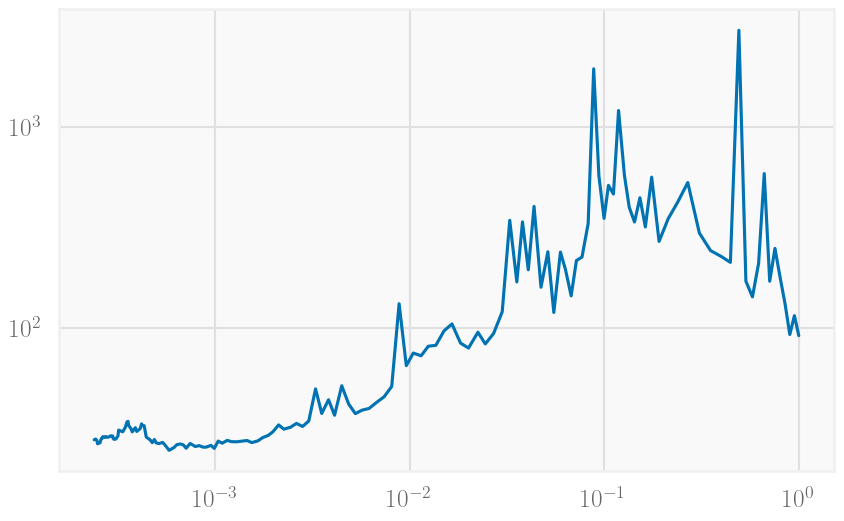

: 

: 

In [ ]:
plt.plot(rel_err_vals, jnp.mean(jnp.array(out['grad_mag']['value']),axis=1))
plt.yscale('log')
plt.xscale('log')

In [12]:
rel_err_vals = jnp.array(rel_err_vals)  # Fill in with actual values

# Generate powers of 2^-n in the given range
n_max = int(jnp.log2(rel_err_vals[0]))  # Estimate maximum n where 2^-n is relevant
n_min = int(jnp.log2(rel_err_vals[-1]))  # Estimate minimum n based on smallest value

powers_of_two = 1 / 2 ** (-jnp.arange(n_min, n_max + 1))  # Generate 2^-n values

# Find the closest index for each power of 2^-n
indices = [jnp.argmin(jnp.abs(rel_err_vals - p)) for p in powers_of_two]

: 

: 

In [ ]:
powers_of_two

Array([2.44140625e-04, 4.88281250e-04, 9.76562500e-04, 1.95312500e-03,
       3.90625000e-03, 7.81250000e-03, 1.56250000e-02, 3.12500000e-02,
       6.25000000e-02, 1.25000000e-01, 2.50000000e-01, 5.00000000e-01,
       1.00000000e+00], dtype=float64)

: 

: 

In [ ]:
indices

[Array(147, dtype=int64),
 Array(108, dtype=int64),
 Array(90, dtype=int64),
 Array(78, dtype=int64),
 Array(69, dtype=int64),
 Array(60, dtype=int64),
 Array(53, dtype=int64),
 Array(46, dtype=int64),
 Array(36, dtype=int64),
 Array(25, dtype=int64),
 Array(17, dtype=int64),
 Array(11, dtype=int64),
 Array(0, dtype=int64)]

: 

: 

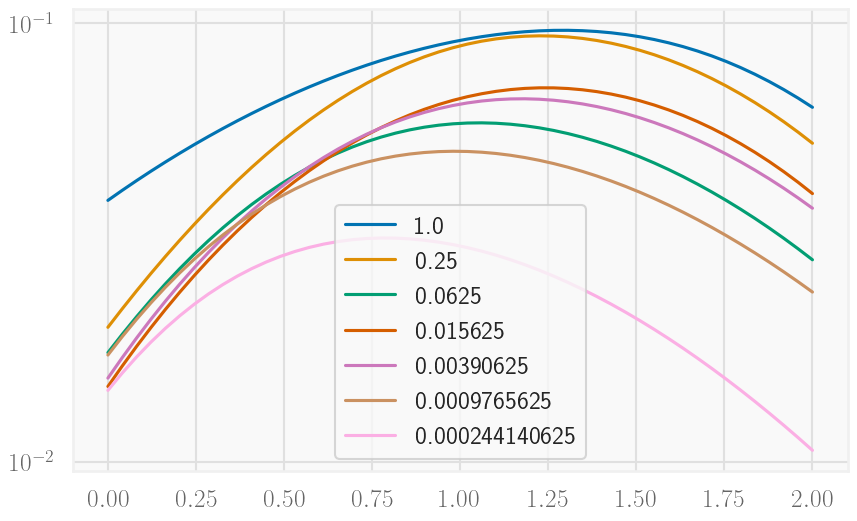

: 

: 

In [ ]:
for (idx,index) in enumerate(sorted(indices)):
    if idx%2 ==0:
        
        plt.plot(jnp.linspace(0,2,50),jnp.array(out['snr_a']['value']).T[:,index], label = powers_of_two[-idx-1])
plt.yscale('log')
plt.legend()

In [16]:
# estimate local grad
fs_state = FullSumState(hilbert = gs.state.hilbert, model = gs.state.model, chunk_size=None, seed=0)
fs_state.variables = copy.deepcopy(gs.state.variables)
pdf = fs_state.probability_distribution()
vstate_arr = fs_state.to_array()
Hloc = trainer.model.hamiltonian.to_sparse() @ vstate_arr / vstate_arr
Hloc_c = (Hloc - jnp.sum(Hloc*pdf))
mode = "holomorphic"
# uncentered jacobian
jacobian_orig = nkjax.jacobian(
    fs_state._apply_fun,
    fs_state.parameters,
    fs_state.hilbert.all_states(), #in MC state, this is vstate.samples
    fs_state.model_state,
    pdf=pdf,
    mode=mode,
    dense=True,
    center=False,
    chunk_size=10,
    _sqrt_rescale=False, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
)

: 

: 

In [ ]:
jnp.sum(pdf * Hloc)

Array(-33.70315544+2.09901541e-16j, dtype=complex128)

: 

: 

In [18]:
jacobian_orig_c = jacobian_orig - jnp.sum(jacobian_orig*pdf[:,None],axis=0)
loc_grad_v = jacobian_orig_c.conj().T * Hloc_c
loc_grad_c = jnp.abs(loc_grad_v - jnp.mean(loc_grad_v, axis=1)[:,None])

mean_grad = jnp.sum(jnp.abs(pdf * loc_grad_c), axis=0)/ jnp.sum(jnp.abs(pdf * loc_grad_c))
mean_grad_unc = jnp.sum(jnp.abs(pdf * loc_grad_v), axis=0) / jnp.sum(jnp.abs(pdf * loc_grad_v))

: 

: 

In [ ]:
jnp.sum(mean_grad_unc)

Array(1., dtype=float64)

: 

: 

In [20]:
# with reweighting |\psi|
alpha = 1
mod_pdf = jnp.abs(vstate_arr)**alpha/jnp.sum(jnp.abs(vstate_arr)**alpha)
# plt.plot(mod_1_pdf)
# plt.yscale('log')
def mod_pdf_fun(alpha):
    return (jnp.abs(vstate_arr)**alpha)/jnp.sum(jnp.abs(vstate_arr)**alpha)

def unnorm_pdf(alpha):
    return (jnp.abs(vstate_arr)**alpha)

: 

: 

In [21]:
from grad_sample.utils.tree_op import shape_tree
def compute_snr_is(q):
    # compute variance of gradient from global variables and specified pdf
    q_pdf = q / jnp.sum(q)
    w_mean = jnp.sum(q_pdf * unnorm_pdf(2.0)/q)**2
    v = jnp.sum(q_pdf * (unnorm_pdf(2.0)/q)**2 * jnp.abs(loc_grad_v - jnp.sum(pdf * loc_grad_v, axis=1)[:, None])**2, axis=1)/w_mean
    return jnp.mean(jnp.abs(jnp.sum(pdf * loc_grad_v, axis = 1)) / jnp.sqrt(v))

def compute_grad_snr_is(q, log_jac_q):
    # takes an unormalized distribution and the gradient of its log probability (uncentered around its expectation under q, done here)
    q_pdf = q / jnp.sum(q)
    w_mean = jnp.sum(q_pdf * unnorm_pdf(2.0)/q)**2
    v = jnp.sum(q_pdf * (unnorm_pdf(2.0)/q)**2 * jnp.abs(loc_grad_v - jnp.sum(pdf * loc_grad_v, axis=1)[:, None])**2, axis=1)/w_mean
    loc_var = q_pdf * (unnorm_pdf(2.0)/q)**2 * jnp.abs(loc_grad_v - jnp.sum(pdf * loc_grad_v, axis=1)[:, None])**2/w_mean # (N_P, N_S)
    
    log_jac_q_ct = jax.tree_util.tree_map(lambda x: (x.T - jnp.sum(q_pdf * x.T, axis=1)[:,None]), log_jac_q) # (N_Pis, N_S)
    grad_v = jax.tree_util.tree_map(
        lambda x: x @ loc_var.T,
        log_jac_q_ct)
    
    snr_for_grad = 1/2 * jnp.abs(jnp.sum(pdf * loc_grad_v, axis = 1))/(v)**(3/2)
    
    grad_snr = tree_map(lambda g : g * snr_for_grad, grad_v) #(N_P, N_Pis)

    return tree_map(lambda g: jnp.mean(g, axis=-1), grad_snr)

: 

: 

In [22]:
from advanced_drivers._src.driver.ngd.distribution_constructors.overdispersed import aux_fun_diff, aux_fun_mixture_diff, aux_fun_smeared_diff
from functools import partial


: 

: 

In [ ]:
from copy import deepcopy
delta = 1e-9
# is_distrib = advd.driver.overdispersed_distribution(0.8)
is_distrib = advd.driver.overdispersed_mixture_distribution(3)
# is_distrib = advd.driver.overdispersed_smeared_distribution(2.0)

diff_fun = partial(is_distrib.grad_func, gs.state._apply_fun, gs.state.variables)
is_fun, is_vars = is_distrib(gs.state._apply_fun, gs.state.variables)
alpha_diff = nkjax.jacobian(
    diff_fun,
    is_distrib.q_variables,
    gs.state.hilbert.all_states(), #in MC state, this is vstate.samples
    {},
    mode='real',
    dense=False,
    center=False,
    _sqrt_rescale=False,
    )
# print(alpha_diff)
q_vars_mod = deepcopy(is_vars)
# q_vars_mod['alpha'] = q_vars_mod['alpha'].at[0].add(delta)
q_vars_mod['lambda'] = q_vars_mod['lambda'].at[0].add(delta)

# q_vars_mod['alpha'] = q_vars_mod['alpha'] + delta
unnorm_is_pdf = jnp.exp(2* jnp.real(is_fun(is_vars, gs.state.hilbert.all_states())))
unnorm_is_pdf_mod = jnp.exp(2* jnp.real(is_fun(q_vars_mod, gs.state.hilbert.all_states())))
grad_snr = compute_grad_snr_is(unnorm_is_pdf, alpha_diff)
print(grad_snr)
print((compute_snr_is(unnorm_is_pdf_mod) - compute_snr_is(unnorm_is_pdf))/delta)
snr = compute_snr_is(unnorm_is_pdf)
print(shape_tree(alpha_diff))

{'lambda': Array([ 7.71522123e-05,  4.93983528e-04, -5.71135740e-04], dtype=float64)}
7.715703076449643e-05
{'lambda': (12870, 3)}


: 

: 

In [23]:
# psi_alpha_arr = jnp.exp(jnp.real(gs.state._apply_fun(gs.state.variables, gs.state.hilbert.all_states()))[:,None])**(is_distrib.alpha)
# lmd = jnp.array([0, 1, 0])
# print((lmd * psi_alpha_arr).shape)
# psi_alpha_arr / (jnp.sum(lmd * psi_alpha_arr, axis=1))[:,None]

: 

: 

[0.50011353 0.87543594 1.25181869 1.63060911 1.91977636]
[0.5031168  0.88835268 1.2694699  1.36933477 1.36979979]
[0.50947379 0.90694072 1.12112755 1.12683762 1.12684981]
[0.51651875 0.89948365 0.99194098 0.99285828 0.99286018]
[0.52206329 0.87211477 0.91744871 0.91777713 0.91777781]


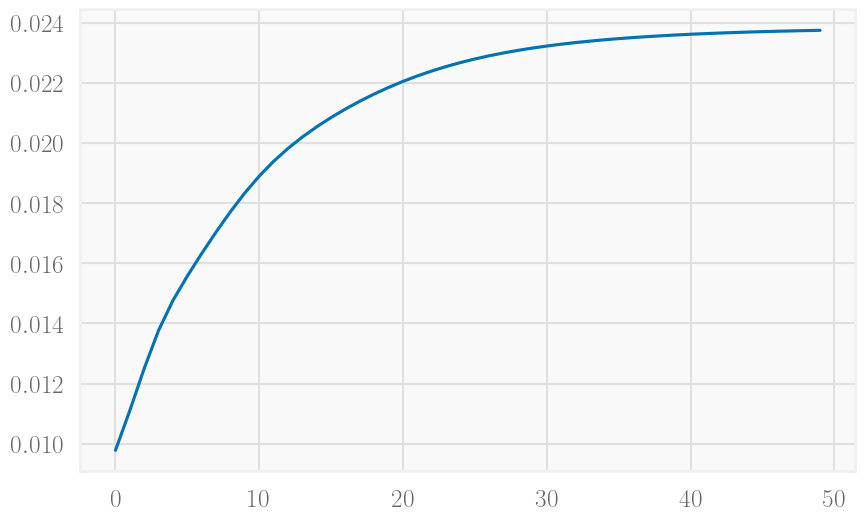

: 

: 

In [24]:
lr = 5
snr_l = []
# is_distrib = advd.driver.overdispersed_distribution(0.0)
# is_distrib = advd.driver.overdispersed_mixture_distribution(2)
is_distrib = advd.driver.overdispersed_mean_distribution(5)
# is_distrib = advd.driver.overdispersed_smeared_distribution(2.0)
for i in range(50):
    diff_fun = partial(is_distrib.grad_func, gs.state._apply_fun, gs.state.variables)
    is_fun, is_vars = is_distrib(gs.state._apply_fun, gs.state.variables)
    alpha_diff = nkjax.jacobian(
        diff_fun,
        is_distrib.q_variables,
        gs.state.hilbert.all_states(), #in MC state, this is vstate.samples
        {},
        mode='real',
        dense=False,
        center=False,
        _sqrt_rescale=False,
        )
    
    unnorm_is_pdf = jnp.exp(2* jnp.real(is_fun(is_vars, gs.state.hilbert.all_states())))
    # print(alpha_diff)
    grad_snr = compute_grad_snr_is(unnorm_is_pdf, alpha_diff)
    snr = compute_snr_is(unnorm_is_pdf)
    is_distrib.q_variables = jax.tree_util.tree_map(lambda x,y : x + lr * y, is_distrib.q_variables, grad_snr)
    if i %10 == 0:
        # print(grad_snr)
        if 'lambda' in is_distrib.q_variables.keys():
            print(jax.nn.relu(is_distrib.q_variables['lambda']))
        else:
            print(is_distrib.q_variables['alpha'])
        # print(jax.tree_util.tree_map(lambda x: x, is_distrib.q_variables))
    snr_l.append(snr)
plt.plot(snr_l)

In [ ]:
is_distrib.q_variables

{'alpha': Array(2., dtype=float64, weak_type=True)}

: 

: 

In [ ]:
log_psi = 2 * jnp.ones(100)
alpha = 1.5 * jnp.ones(10)
ld = 1/2 * jnp.ones(10)

jnp.sum(ld * log_psi[:, None] ** alpha, axis = 1).shape


(100,)

: 

: 

In [26]:
print(compute_snr_is(unnorm_pdf(1.0)))
print(compute_snr_is(unnorm_pdf(2.0)))

# loss
print(compute_snr_is(unnorm_pdf(2.0) * jnp.abs(Hloc)))

# Hpsi
print(compute_snr_is( jnp.abs(trainer.model.hamiltonian.to_sparse() @ vstate_arr)))
# uncentered gradient
print(compute_snr_is(jnp.mean(unnorm_pdf(2.0) * jnp.abs(loc_grad_v), axis=0)))
# centered gradient
print(compute_snr_is(unnorm_pdf(2.0) * jnp.abs(loc_grad_c)))

0.02309866442038172
0.009171658176346083
0.0071345977654394335
0.01969804010663094
0.05781719268878503
0.2963391618770878


: 

: 

In [27]:
snr_grad = compute_snr_is(jnp.mean(unnorm_pdf(2.0) * jnp.abs(loc_grad_v),axis=0))

: 

: 

In [28]:
snr_hpsi = compute_snr_is( jnp.abs(trainer.model.hamiltonian.to_sparse() @ vstate_arr))

: 

: 

In [29]:
def kl_dist(p1, p2):
    return jnp.sum(p1 * jnp.log(p1/p2))

: 

: 

In [ ]:
jnp.sum(mean_grad_unc)

Array(1., dtype=float64)

: 

: 

/tmp/ipykernel_1820792/732689765.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor = (1.5,1), fontsize=18)


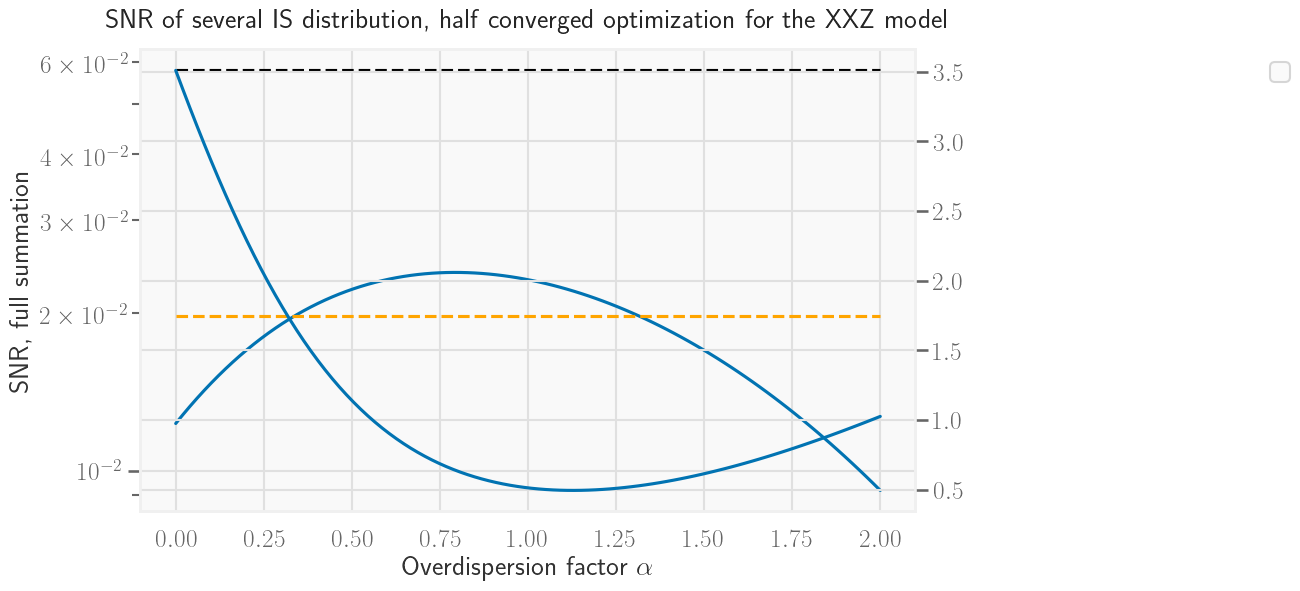

: 

: 

In [33]:
fig, ax = plt.subplots()
ax1  =ax.twinx()
ax1.plot(jnp.linspace(0,2,100), [kl_dist(mod_pdf_fun(a), mean_grad_unc) for a in jnp.linspace(0,2,100)])
ax.plot(jnp.linspace(0,2,100), [compute_snr_is(unnorm_pdf(a)) for a in jnp.linspace(0,2,100)], label = 'SNR with overdispersion')
ax.hlines(snr_grad, 0,2, linestyle='--', color= 'black', label=r'SNR using $\frac{1}{N_p}\sum_i p(x)|F_i^{loc}(x)|$')
ax.hlines(snr_hpsi, 0,2, linestyle='--', color= 'orange', label=r'SNR using $|\bra{x} H \ket{\psi}|$')
# ax.hlines(max(snr_l), 0,2, linestyle='--', color= 'red', label=r'SNR from autotuning')
# ax.set_ylabel(r'$KL(\frac{1}{N_p}\sum_i p(x)|F_i^{loc}(x)|, q_\alpha)$')
ax.set_xlabel(r'Overdispersion factor $\alpha$')
ax.set_ylabel(r"SNR, full summation")
ax.set_yscale('log')
plt.title(r'SNR of several IS distribution, half converged optimization for the XXZ model')
plt.legend(bbox_to_anchor = (1.5,1), fontsize=18)

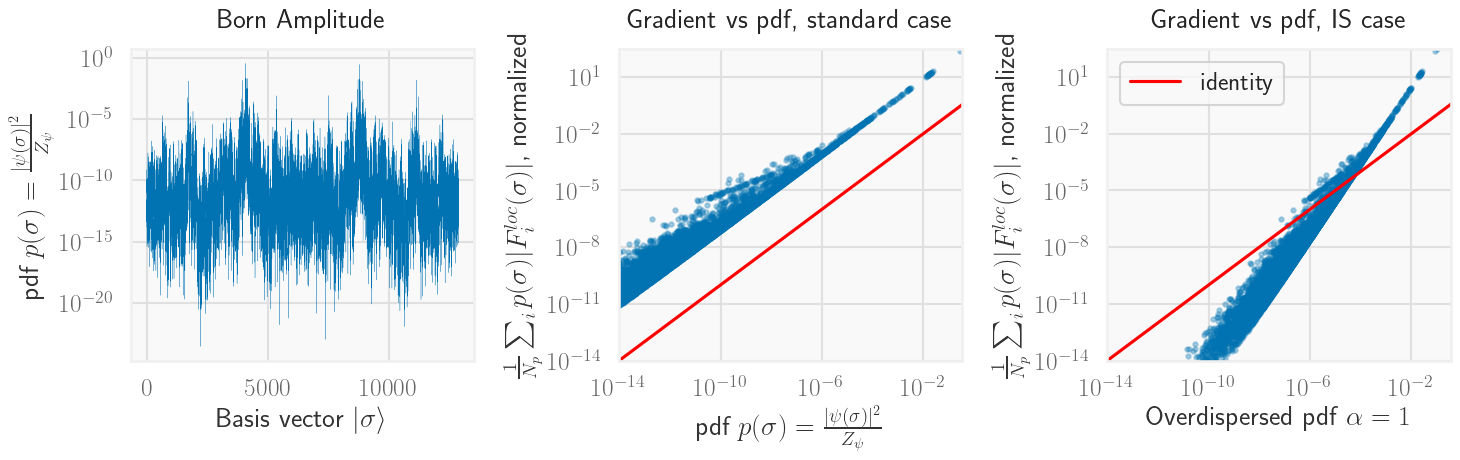

: 

: 

: 

: 

: 

: 

: 

: 

In [125]:
# plt.plot(jnp.mean(loc_grad, axis=0))
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(pdf, linewidth=0.2)
axes[0].set_yscale('log')
axes[1].set_xscale('log')
axes[0].set_xlabel(r'Basis vector $\ket{\sigma}$')
axes[0].set_ylabel(r'pdf $p(\sigma) = \frac{|\psi(\sigma)|^2}{Z_\psi}$')
axes[0].set_title('Born Amplitude')
axes[1].set_yscale('log')

axes[1].scatter(pdf, mean_grad, alpha=0.3, s=10)
# axes[1].scatter(pdf, jnp.abs(loc_grad_rescaled[0]))
id_y = jnp.linspace(min(mean_grad), max(mean_grad), 10)
axes[1].plot(id_y, id_y, color = 'red')
axes[1].set_ylabel(r'$\frac{1}{N_p}\sum_i p(\sigma)|F_i^{loc}(\sigma)|$, normalized')
axes[1].set_xlabel(r'pdf $p(\sigma) = \frac{|\psi(\sigma)|^2}{Z_\psi}$')
axes[1].set_title('Gradient vs pdf, standard case')

# axes[0].set_ylim(1e-14, max(pdf))
axes[1].set_ylim(1e-14, max(mean_grad))
axes[2].set_ylim(1e-14, max(mean_grad))
axes[1].set_xlim(1e-14, max(pdf))
axes[2].set_xlim(1e-14, max(pdf))

axes[2].plot(id_y, id_y, color = 'red', label = 'identity')
axes[2].scatter(mod_pdf, mean_grad, alpha=0.3, s=10)
axes[2].set_title('Gradient vs pdf, IS case')
axes[2].set_ylabel(r'$\frac{1}{N_p}\sum_i p(\sigma)|F_i^{loc}(\sigma)|$, normalized')
axes[2].set_xlabel(r'Overdispersed pdf $\alpha = 1$')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
plt.legend()
fig.tight_layout()

In [14]:
import copy

def apply_gradient(optimizer_fun, optimizer_state, dp, params):
    updates, new_optimizer_state = optimizer_fun(dp, optimizer_state, params)

    new_params = optax.apply_updates(params, updates)

    return new_optimizer_state, new_params
    return True

def rel_err_fs(vstate, fs_state, is_op, e_gs):
    fs_state.variables = copy.deepcopy(vstate.variables)
    # e = fs_state.expect(driver._ham.operator).mean.real
    e = fs_state.expect(is_op.operator).mean.real
    return jnp.abs(e-e_gs)/jnp.abs(e_gs)

: 

: 

: 

: 

: 

: 

: 

: 

In [15]:
import numpy as np
from tqdm import tqdm
from netket.vqs import FullSumState

def train_adapt(update_type='opt', update_stride=10, alpha_s=2.0, n_iter=2000):  
    '''
    Typical params
    update_type = 'opt' #opt or heur
    update_stride = 10

    update_type = 'heur' #opt or heur
    update_stride = 2
    '''
    # Initialize variables
    warmup = 50
    lr = 0.005
    epsilon = 1e-8  # Small constant to prevent division by zero
    stride_rel_err = 20
    # Define the optimizer
    # alpha_opt = optax.adam(learning_rate=0.03, eps=1e-8)  # Adagrad optimizer
    alpha_opt = optax.sgd(learning_rate=0.05)
    alpha_opt_state = alpha_opt.init(alpha_s) 

    fs_state_rel_err = FullSumState(hilbert = trainer.vstate.hilbert, model = trainer.vstate.model, chunk_size=None, seed=0)
        
    al = []
    itvar = []
    snrl = []
    gradvarl = []
    itrel = []
    rel_errl = []
    is_ops = IS_Operator(operator=trainer.model.hamiltonian.to_jax_operator(), is_mode=alpha_s)
    # trainer.vstate.init_parameters(seed=0)
    trainer.vstate.init_parameters()
    opt_state = trainer.opt.init(trainer.vstate.parameters)

    with tqdm(
                    total=n_iter,
                    disable=False,
                    dynamic_ncols=True,
                ) as pbar:
        # Optimization loop
        for n in tqdm(range(n_iter)):
            # Create IS operator and get log importance weights
            log_qs, log_qs_vars = is_ops.get_log_importance(trainer.vstate)
            
            # Sample from the distribution
            samples_alphas = trainer.vstate.sample_distribution(
                log_qs,
                variables=log_qs_vars,
                n_samples=trainer.Nsample
            )
            if n%update_stride ==1 and n > warmup:
                O_exp, O_grad, ng, snr, grad_var = _compute_S_F_var(
                samples_alphas,
                trainer.vstate._apply_fun,
                trainer.vstate.parameters,
                trainer.vstate.model_state,
                log_qs,
                log_qs_vars,
                trainer.chunk_size_jac // 2,
                is_ops,
                trainer.solver_fn,
                1e-4,
                )  
                # Compute mean of variance and gradient variance
                snrl.append(pytree_mean(snr))
                grad_var_mean = pytree_mean(grad_var)
                gradvarl.append(grad_var_mean)
                al.append(alpha_s)

                itvar.append(n)

                if update_type == 'opt':
                    # optax update
                    updates, alpha_opt_state = alpha_opt.update(grad_var_mean, alpha_opt_state)
                    alpha_s_new = optax.apply_updates(alpha_s, updates)  # Update alpha_s
                    if alpha_s_new > 0:
                        alpha_s = alpha_s_new
                        is_ops._is_mode = alpha_s 
                # heuristic update
                elif update_type == 'heur':
                    if grad_var_mean > 0:
                        alpha_s_new = alpha_s - lr
                    else:
                        alpha_s_new = alpha_s + lr
                    
                    if alpha_s_new > 0:
                        alpha_s = alpha_s_new
                        is_ops._is_mode = alpha_s 
                    # is_ops = IS_Operator(operator=trainer.model.H_jax, is_mode=alpha_s)

            else:
                O_exp, O_grad, ng = _compute_S_F(
                samples_alphas,
                trainer.vstate._apply_fun,
                trainer.vstate.parameters,
                trainer.vstate.model_state,
                log_qs,
                log_qs_vars,
                trainer.chunk_size_jac // 2,
                is_ops,
                trainer.solver_fn,
                1e-4,
                )  

            opt_state, trainer.vstate.parameters = apply_gradient(trainer.opt.update, opt_state, ng[0], trainer.vstate.parameters)
            
            if n%stride_rel_err == 0:
                rel_errl.append(rel_err_fs(trainer.vstate, fs_state_rel_err, is_ops, trainer.E_gs))
                itrel.append(n)
            pbar.set_postfix_str(
                        "E = %s ; alpha = %.2f"%(O_exp, alpha_s)
                        )
            pbar.update(1)

    return al, itvar, snrl, gradvarl, itrel, rel_errl

: 

: 

: 

: 

: 

: 

: 

: 

In [16]:
for i in range(5):
    al, itvar, snrl, gradvarl, itrel, rel_errl = train_adapt(update_type='opt', update_stride=10, alpha_s=1.0, n_iter=8000)
    out_dict = {'al': al, 'itvar': itvar, 'snrl': snrl, 'gradvarl': gradvarl, 'itrel': itrel, 'rel_errl': rel_errl}
    jnp.savez(f"run_1_start_{i}.npz", out_dict )

  0%|          | 0/8000 [00:00<?, ?it/s]/home/amisery/phd/netket_pro/packages/netket_pro/_src/monkeypatch/mcstate_sampling.py:202: UserWarning: 
                !!!!!!!!!!!!!!!!!!!!!!!!!!
                !!! Paris People read! !!!
                !!!!!!!!!!!!!!!!!!!!!!!!!!

                Calling sample_distribution without a name is deprecated.
                From now on you should always provide a name for the chain you are sampling.
                Using the same name in multiple places will lead to the same chain to be used in
                both places.

                using default name: grad_sample.is_hpsi.is_utils._logpsi_smeared_fun
                
  warnings.warn(warning_msg.format(chain_name=chain_name))


(512, 16)


  0%|          | 1/8000 [00:11<26:30:59, 11.93s/it, E = 15.379127627423852 ; alpha = 1.00]/home/amisery/phd/netket_pro/packages/netket_pro/_src/monkeypatch/mcstate_sampling.py:202: UserWarning: 
                !!!!!!!!!!!!!!!!!!!!!!!!!!
                !!! Paris People read! !!!
                !!!!!!!!!!!!!!!!!!!!!!!!!!

                Calling sample_distribution without a name is deprecated.
                From now on you should always provide a name for the chain you are sampling.
                Using the same name in multiple places will lead to the same chain to be used in
                both places.

                using default name: grad_sample.is_hpsi.is_utils._logpsi_smeared_fun
                
  warnings.warn(warning_msg.format(chain_name=chain_name))
  1%|          | 51/8000 [00:17<46:12,  2.87it/s, E = -2.3823095502063794 ; alpha = 1.00]


ValueError: too many values to unpack (expected 4)

: 

: 

: 

: 

: 

: 

: 

: 

In [18]:
al, itvar, snrl, gradvarl, itrel, rel_errl = train_adapt(update_type='opt', update_stride=10, alpha_s=2.0)
al_f, itvar_f, snrl_f, _, itrel_f, rel_errl_f = train_adapt(update_type='none', alpha_s=1.0)
al_def, itvar_def, snrl_def, _, itrel_def, rel_errl_def = train_adapt(update_type='none', alpha_s=2.0)

100%|██████████| 2000/2000 [01:16<00:00, 26.03it/s, E = -26.478017448802426 ; alpha = 2.00]


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

Text(0, 0.5, '$\\frac{1}{N_p}\\sum_j\\frac{Var(F_j)}{|F_j|^2}$')

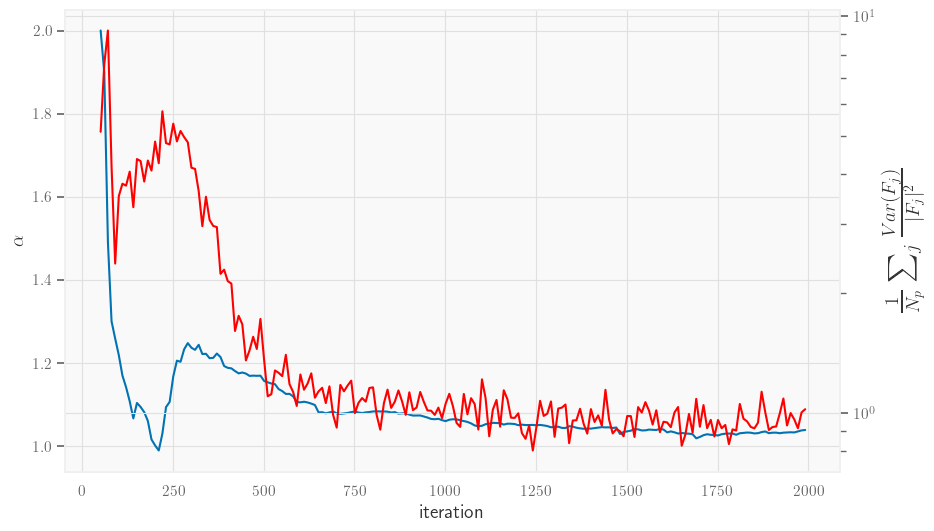

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [19]:
fig, axes = plt.subplots()
axes.plot(itvar, al)
axes1 = axes.twinx()
axes1.plot(itvar, jnp.array(snrl), color='red', label = r'Mean SNR, adaptive $\alpha$')

axes1.set_yscale('log')

axes.set_xlabel('iteration')
axes.set_ylabel(r'$\alpha$')
axes1.set_ylabel(r'$\frac{1}{N_p}\sum_j\frac{Var(F_j)}{|F_j|^2}$', fontsize=20)

# fig.suptitle(r'Automatic tuning of $\alpha$, update every %d, warmup of %d steps, heuristic step %.2f'%(update_stride, warmup, lr))

Text(0, 0.5, '$\\frac{1}{N_p}\\sum_j\\frac{Var(F_j)}{|F_j|^2}$')

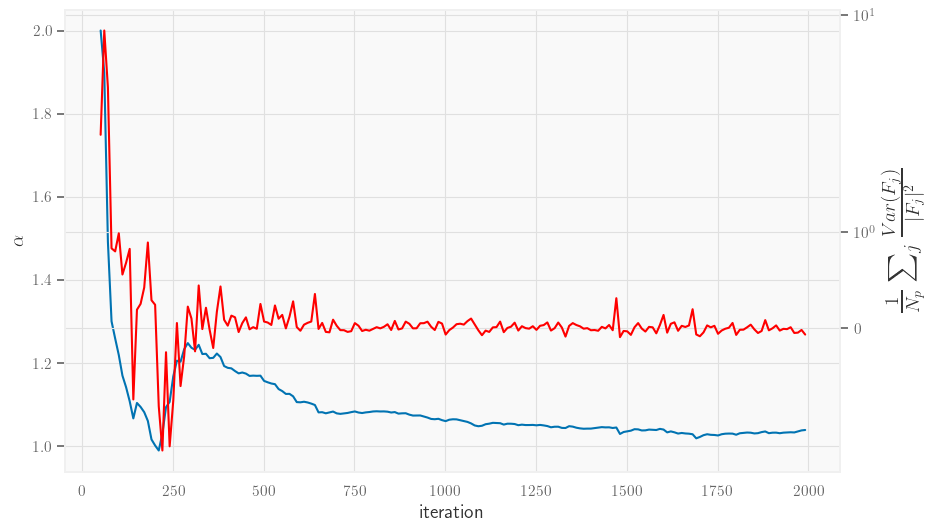

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [20]:
fig, axes = plt.subplots()
axes.plot(itvar, al)
axes1 = axes.twinx()
axes1.plot(itvar, jnp.array(gradvarl), color='red', label = r'Mean SNR, adaptive $\alpha$')

axes1.set_yscale('symlog')

axes.set_xlabel('iteration')
axes.set_ylabel(r'$\alpha$')
axes1.set_ylabel(r'$\frac{1}{N_p}\sum_j\frac{Var(F_j)}{|F_j|^2}$', fontsize=20)

Text(0.5, 0.98, 'Relative error and gradient variance, no tuning')

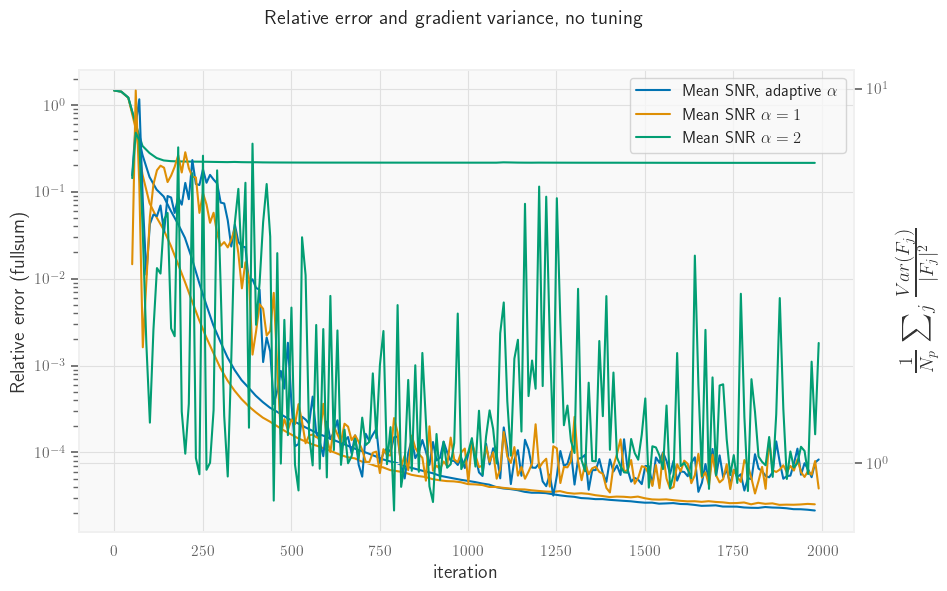

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [22]:
fig, axes = plt.subplots()

axes.plot(itrel, rel_errl)
axes.plot(itrel_f, rel_errl_f)
axes.plot(itrel_def, rel_errl_def)
axes.set_yscale('log')
axes1 = axes.twinx()
axes1.plot(itvar, jnp.array(snrl),  label = r'Mean SNR, adaptive $\alpha$')
axes1.plot(itvar_f, jnp.array(snrl_f), label = r'Mean SNR $\alpha=1$')
axes1.plot(itvar_def, jnp.array(snrl_def), label = r'Mean SNR $\alpha=2$')
axes1.set_yscale('symlog')

axes.set_xlabel('iteration')
axes.set_ylabel('Relative error (fullsum)')
axes1.set_ylabel(r'$\frac{1}{N_p}\sum_j\frac{Var(F_j)}{|F_j|^2}$', fontsize=20)
plt.legend()
fig.suptitle('Relative error and gradient variance, no tuning')